# Sheet 2 - Hopfield Network

In [212]:
!pip install numpy
!pip install matplotlib

In [213]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib import colors
from matplotlib.image import AxesImage
from typing import Final

import string

from numpy.typing import NDArray

In [214]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 300

RNG: Final[np.random.Generator] = np.random.default_rng(42)

In [215]:
class HopfieldNetwork:

    def __init__(self, patterns: NDArray[np.int8], rng: np.random.Generator = RNG) -> None:
        """Initalizes a Hopfield Network.

        Args:
            patterns: ... Shape: [#patterns, pattern_size]
        """
        if patterns.ndim != 2:
            raise ValueError("...")

        self._patterns = patterns  # Shape: [#patterns, pattern_size], where pattern_size = #neurons
        self.w = self._initialize_weights()  # Shape: [#neurons, #neurons]

        self.rng = rng
    
    def _initialize_weights(self) -> NDArray[np.float64]:
        w: NDArray[float64] = np.zeros((self.num_neurons, self.num_neurons), dtype=np.float64)
        for pattern in self._patterns:
            w += np.outer(pattern, pattern)
        
        # No self-connections
        np.fill_diagonal(w, 0)

        return w

    def update_state(self, state: NDArray[np.int8], synchron: bool = True) -> NDArray[np.int8]:
        """
        Args:
            state: ... Shape: [#neurons]
        """
        updated_state: NDArray[np.int8]

        if synchron:
            updated_state = np.sign(self.w @ state).astype(np.int8)
        else:
            unit_index: np.uint64 = self.rng.integers(low=0, high=self.num_neurons)
            updated_state = state.copy()
            updated_state[unit_index] = np.sign(self.w[unit_index].T @ state)

        return updated_state

    def stabilize(self, state: NDArray[np.int8], synchron: bool = True) -> tuple[NDArray[np.int8], NDArray[np.float64]]:
        energies: list[np.float64] = [self.get_energy(state)]
        
        while True:
            # Checking for convergence via 'is_stable' for every iteration could also be integrated 
            # into the function's state updates. We refrained from it for readability purposes.

            # TODO: Is it legal to use a synchronous update to check stability here? 
            #       Otherwise, we would need to check if the energy does not decrease 
            #       after every neuron has been updated asynchronously.
            if self.is_stable(state): 
                break

            state = self.update_state(state, synchron=synchron)
            energies.append(self.get_energy(state))

        return state, np.array(energies, dtype=np.float64)
    
    def is_stable(self, state: NDArray[np.int8]) -> bool:
        return np.array_equal(state, self.update_state(state, synchron=True))

    def get_energy(self, state: NDArray[np.int8]) -> np.float64:
        return -0.5 * (state @ self.w @ state.T)
    
    @property
    def patterns(self) -> NDArray[np.int8]:
        return self._patterns

    @property
    def num_neurons(self) -> int:
        # The number of neurons corresponds to the dimensionality of the patterns (pattern_size = #neurons).
        return self._patterns.shape[1]

In [216]:
def plot_weights(figure: Figure, ax: Axes, weights: NDArray[np.float64]) -> None:
    image: AxesImage = ax.imshow(
        weights, norm=colors.TwoSlopeNorm(vcenter=0), interpolation="None", cmap="coolwarm"
    )
    figure.colorbar(image)

    for (j, i), label in np.ndenumerate(weights):
        ax.text(i, j, label, ha='center', va='center')
    
    weight_range: NDArray[np.int64] = np.arange(len(weights))
    ax.set_xticks(weight_range)
    ax.set_yticks(weight_range)

    ax.set_xlabel("Index")
    ax.set_ylabel("Index")
    
    ax.grid(False)

In [217]:
def plot_state(ax: Axes, state: NDArray[np.int8]) -> None:
    image_array: NDArray[np.uint8] = np.expand_dims(state, axis=0)
    image_array[image_array == -1] = 0

    image: AxesImage = ax.imshow(image_array, cmap="cividis")

    state_values: list[int] = [-1, 1]
    state_colors: list[int] = [image.cmap(image.norm(value)) for value in state_values]
    patches: list[mpatches.Patch] = [
        mpatches.Patch(color=color, label=f"$S_{{i}}={value:+}$")
        for value, color in zip(state_values, state_colors)
    ]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
        
    ax.set_xticks(np.arange(len(state)))
    ax.set_xlabel("$S_{i}$")
    
    ax.yaxis.set_visible(False)

    ax.grid(False)

In [218]:
def plot_energy_evolution(ax: Axes, energies: NDArray[np.float64]) -> None:
    ax.stem(energies, linefmt="-.")

    ax.set_xticks(np.arange(len(energies)))
    
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Energy $E$")

## Task 1

---

In [219]:
patterns: NDArray[np.int8] = np.array(
    [
        [1, -1, 1, -1],
        [-1, 1, 1, 1],
        [-1, -1, -1, 1],
    ],
    dtype=np.int8
)

hopfield_network: HopfieldNetwork = HopfieldNetwork(patterns)

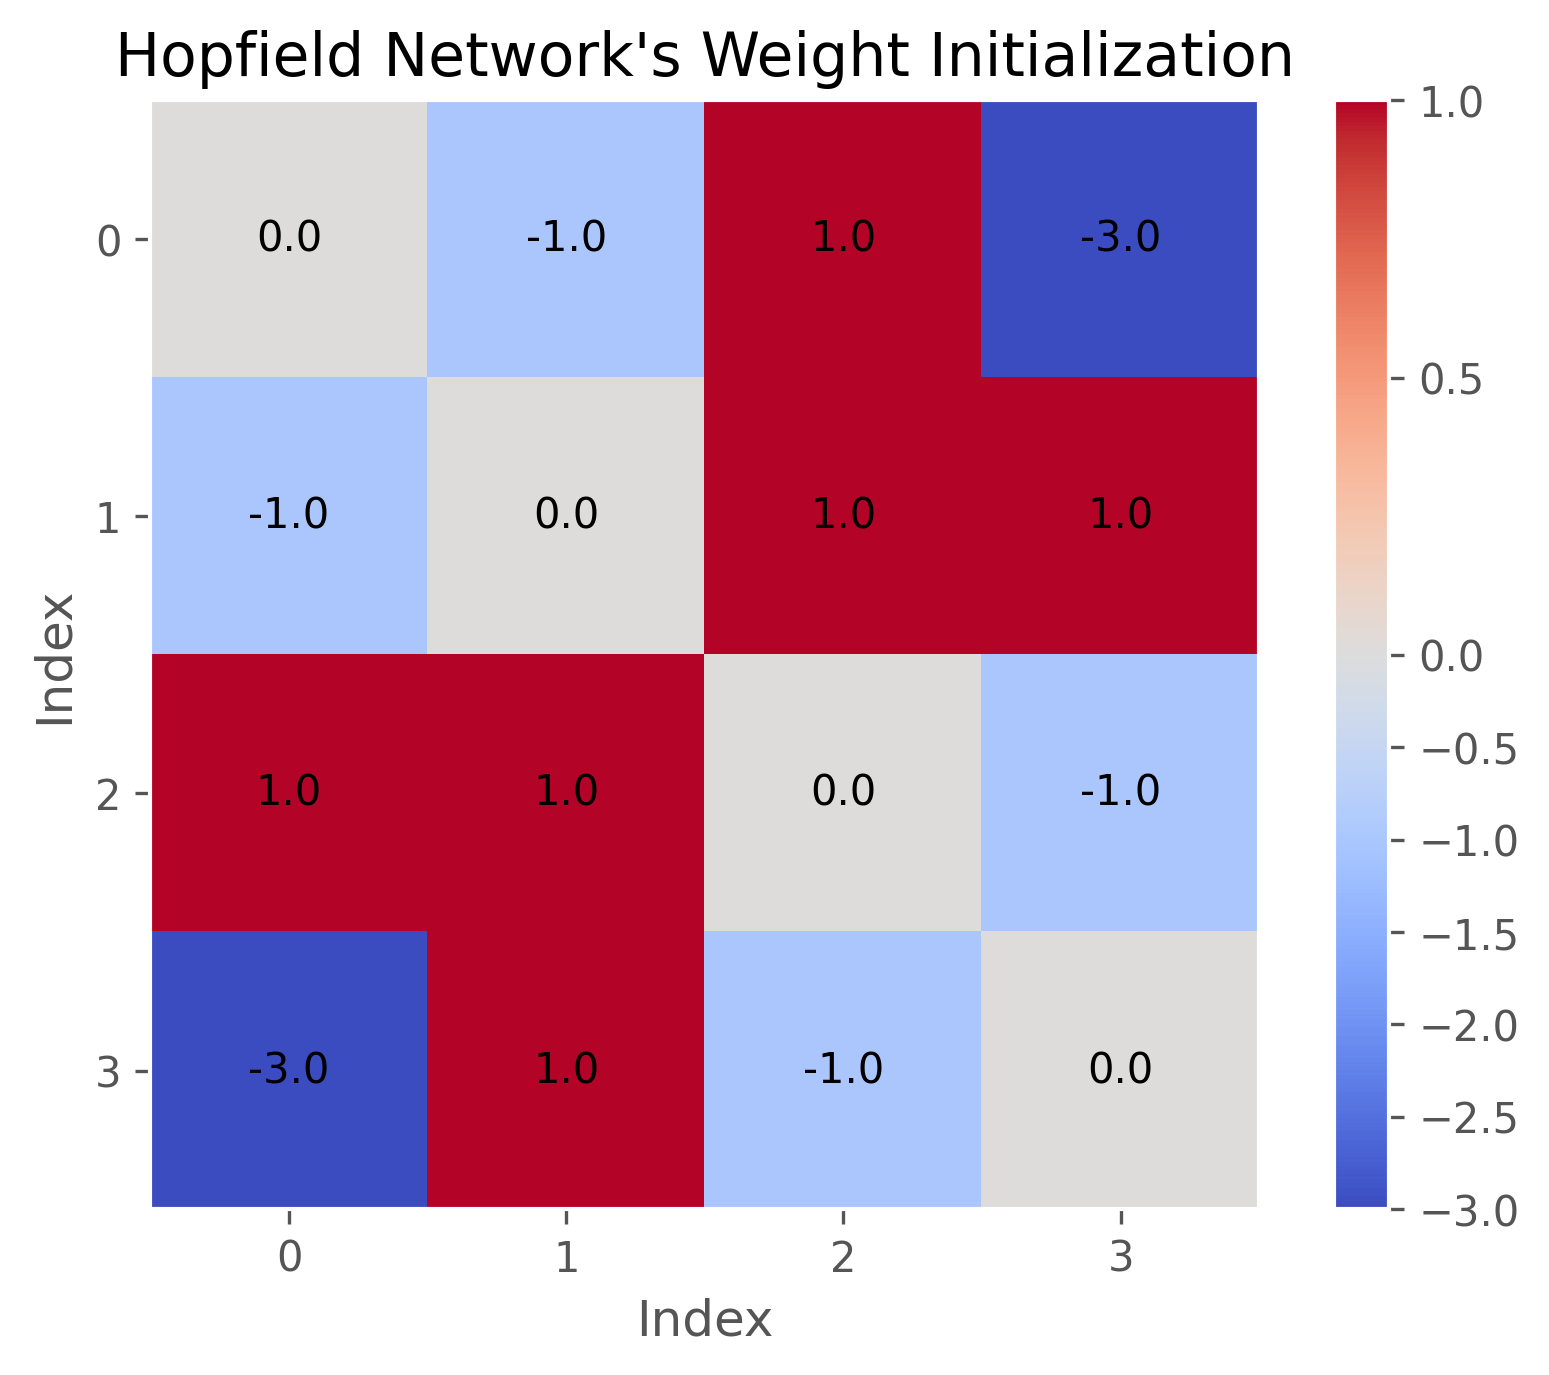

In [220]:
figure, ax = plt.subplots()
plot_weights(figure, ax, hopfield_network.w)
_ = ax.set_title("Hopfield Network's Weight Initialization")

In [221]:
for idx, pattern in zip(("A", "B", "C"), patterns, strict=True):
    if hopfield_network.is_stable(pattern):
        print(f"Pattern {idx} is stable.")
    else:
        print(f"Pattern {idx} is not stable.")

Pattern A is stable.
Pattern B is not stable.
Pattern C is not stable.


## Task 2

---

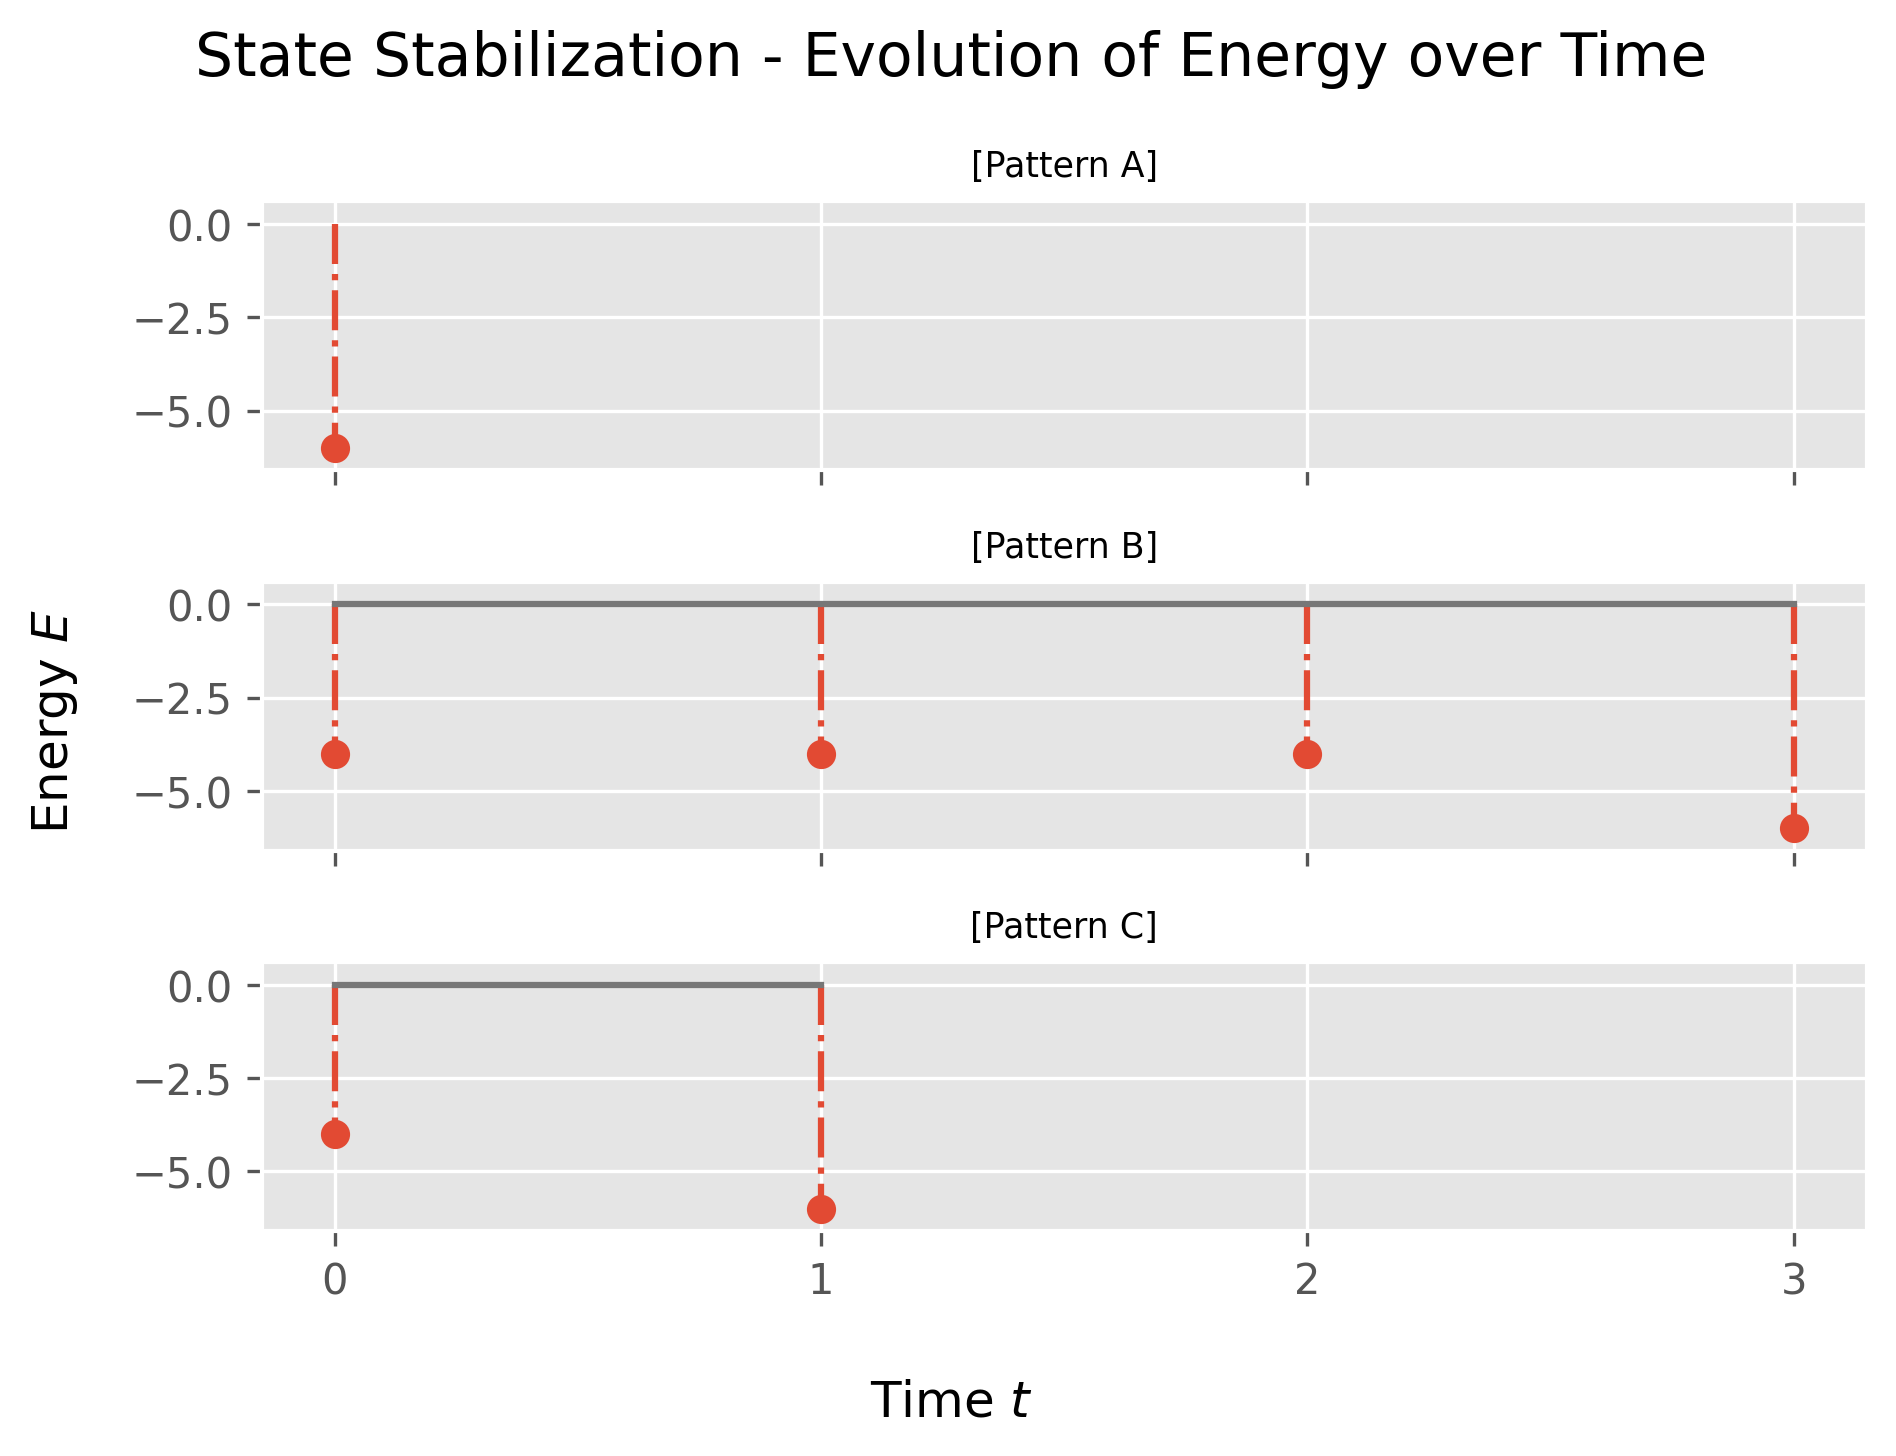

In [222]:
stabelized_states: list[NDArray[np.int8]] = []
energy_evolutions: list[NDArray[np.float64]] = []

for pattern in patterns:
    stabelized_state, energies = hopfield_network.stabilize(pattern, synchron=False)
    stabelized_states.append(stabelized_state)
    energy_evolutions.append(energies)

max_evolution_length: int = max(len(energies) for energies in energy_evolutions)

figure, axes = plt.subplots(len(patterns), sharex=True)
for idx, (ax, energies) in enumerate(zip(axes, energy_evolutions, strict=True)):
    ax.stem(energies, linefmt="-.")

    ax.set_xticks(np.arange(max_evolution_length))

    ax.set_ymargin(0.1)
    
    ax.set_title(f"[Pattern {string.ascii_uppercase[idx]}]", fontsize="small")

figure.supxlabel("Time $t$")
figure.supylabel("Energy $E$")

figure.suptitle("State Stabilization - Evolution of Energy over Time", fontsize="x-large")

figure.tight_layout()

## Task 3

---

In [242]:
images: NDArray[np.int8] = np.load("images.npz")["arr_0"].astype(np.int8)  # Shape: [#patterns, height, width]
flattened_images: NDArray[np.int8] = images.reshape(-1, images.shape[1] * images.shape[2])

hopfield_network = HopfieldNetwork(flattened_images)

In [243]:
for idx, pattern in enumerate(flattened_images):
    if hopfield_network.is_stable(pattern):
        print(f"Pattern {idx} is stable.")
    else:
        print(f"Pattern {idx} is not stable.")

Pattern 0 is stable.
Pattern 1 is stable.
Pattern 2 is not stable.
Pattern 3 is stable.
Pattern 4 is stable.
Pattern 5 is stable.
Pattern 6 is stable.
Pattern 7 is stable.
